### Word embedding (NCS loss)

In this note book we will look at how we can create our ouw word embeddings for a give text.

We start by importing the necessary libraries we need. 

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import pylab
from sklearn.manifold import TSNE

This data is from Wiki, initial lines on word embedding page /the first paragraph. 
Won't go to preprocessing steps, like removing stop words, puntutations, unwanted characters, lowercasing coz a good number of these preprocessing depends on the what you try to achive from your embeddings as such. 

In [2]:
DataRaw = "Understanding the meanings of words is an essential step for natural language processing NLP systems . In recent years there has been an immense interest in methods that learn word representations in an unsupervised manner from massive text collections . Such methods often represent the meanings of words in linear algebraic structures such as vectors that capture lexico semantic information about the word . The usefulness of such word embeddings has been demonstrated by their impressive performances in various NLP tasks such as name entity recognition word similarity measurement sentiment analysis word analogy detection syntactic parsing and dependency parsing . Moreover high quality embeddings of individual words can be used to build semantic representations for larger lexical units such as phrases sentences and documents in a bottom up manner by recursively applying semantic compositional operators on the word level embeddings ."
DataRaw = DataRaw.replace(",", "")

Create a list of unique words, which we use to creat word to integer and integer to word dictionaries. These dictionaries are used for feeding data to our place holders for training, accessing word embeds from lsit of embeds after training, creating one hot representation of the each word and for other computations

We convert all the words to lower case(this is use case sepcific and end results). 

In [3]:
listOfAllWords = [word.lower() for word in DataRaw.split(" ")]
listOfAllWordsUnique = list(set(listOfAllWords))  

Create word2Int and int2Word dictionaries

In [4]:
word2Int = {}
int2Word = {}

for idx, word in enumerate(listOfAllWordsUnique):
    word2Int[word] = idx
    int2Word[idx] = word

Create a list of list to prepare data for building our word embeddings , the inner list is comprised of words in each sentence and outer list is sentences. 

In [5]:
sentences = []
for sentence in DataRaw.split("."):
    sentences.append(sentence.lower().split())

Training data for skip gram: 

Lets discus bit about skip gram data preparation for training.

our aim is to get the vector representation of target word (Wv) with respect to its sourounding words, lwts call it context words(Wc). We can chouse the radius of context words, by this I mean how many context words around our target word we consider, on both sides of target word. 

lets take a sample sentence : "Understanding the meanings of words is an essential step for natural language processing NLP systems"
with radius as 2, we can visualize data represented for our model as: 

Target_Word(Input) : 'language'
Context_words(Output) : ['for','natural','processing','NLP']

Training our model with single input and multiple output is practically difficult to implement. So we break down our data into several single tuples of input and output, (input:'language', output:'for'),(input:'language', output:'natural'),(input:'language', output:'processing'),(input:'language', output:'NLP'). If there is no context word out of predifined radius we ignore thouse data, target word at start or end of sentence, we only consider context word lining at the right and left of target word respectively. 

In [6]:
windowSize = 2
EmbeddingDimension = 2
NegativeSampleSize = 10
Data = []
for sentence in sentences:
    for idx1, word1 in enumerate(sentence):
        if idx1 >+ windowSize:
            for idx2, word2 in enumerate(sentence[idx1-windowSize:idx1+windowSize+1]):
                if word1 != word2:
                    Data.append([word1, word2])
        else:
            for idx3, word3 in enumerate(sentence[0:idx1+windowSize+1]):
                if word1 != word3:
                    Data.append([word, word3])

In [7]:
X_train = []
Y_train = []
vocabSize = len(listOfAllWordsUnique)
for wordlist in Data:
    tempX = []
    X_train.append(word2Int[wordlist[0]])
    Y_train.append(word2Int[wordlist[1]])
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(-1,1)

### Explain skip gram math here

The model we are traninng is a softmax model 

rest is usual NN training, we create a shallow NN with one hidden layer. Dimension of hidden layer weights being of shape size of vocabulary and our desired size(length) of embedded word. Adding Weights and bias of hidden layer will get our word vector. 

We start by defining the placeholders for input and output.
Then embedding layer with dimension of size vocabulary and dimension of embedding word we intentend to. 
later an embedding loop up is create as tensorflow doesn’t allow index lookup with Tensors.

then we define weights of size vocabulary and dimension of embedding word and bias for our soflmax layer. 
After these initialization/definations we calculate loss / train our model using tensorflows nce_loss API. 
When we condiser these embeddings for practicle purposes like sentiment analysis, chatbot, language transulations we need sizeble amount of data, with vocabulary size of (~50000) or more. So is our training becomes cumbursome and slow. To over come this draw back we can use Negative sampling. Where after getting the initial epoch result we consider and fixed amount of netagove samples (words which are not correctly predictied) and same will be used for back propagation eventually to tune the weights. 

"""Therefore, we sample num_sampled number of negative softmax units from full set of V softmax units (units that should have 0 as their output) and calculate the loss only with them. This is found to be very effective approximation to the full softmax but with increased performance."""

In [8]:
X_placeholder = tf.placeholder(shape=[None], dtype=tf.int32)
y_placeholder = tf.placeholder(shape=[None,1], dtype=tf.int32)

In [9]:
embeddings = tf.Variable(tf.random_uniform([vocabSize, EmbeddingDimension],-1.0,1.0))
embed = tf.nn.embedding_lookup(embeddings, X_placeholder)

weights = tf.Variable(tf.truncated_normal([vocabSize, EmbeddingDimension],stddev=1.0/math.sqrt(EmbeddingDimension)))
bias = tf.Variable(tf.zeros([vocabSize]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=weights, biases=bias, labels=y_placeholder, inputs=embed, 
                                     num_sampled=NegativeSampleSize, num_classes=vocabSize))
optimizer = tf.train.AdamOptimizer(1e-1).minimize(loss)

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
epochs = 10000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(epochs):
    _, loss_val = sess.run([optimizer, loss], feed_dict={X_placeholder: X_train, y_placeholder: Y_train})
    
    if epoch % 1000 ==0:
        print("Epoch : ",epoch," loss is : ", loss_val)

Epoch :  0  loss is :  19.309822
Epoch :  1000  loss is :  2.0624614
Epoch :  2000  loss is :  3.0494962
Epoch :  3000  loss is :  2.7986372
Epoch :  4000  loss is :  2.3753746
Epoch :  5000  loss is :  2.8617105
Epoch :  6000  loss is :  2.1510322
Epoch :  7000  loss is :  2.204518
Epoch :  8000  loss is :  2.885724
Epoch :  9000  loss is :  2.9081423


In [12]:
Embeddings = sess.run(normalized_embeddings)
sess.close()

In [ ]:
if embedding.shape[1] == 2:
    labels = listOfAllWordsUnique[:50]
    for i, label in enumerate(labels):
        x,y = embedding[i,:]
        plt.scatter(x,y)
        plt.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',ba='bottom')
        
    plt.show() 
        

In [15]:
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(Embeddings)


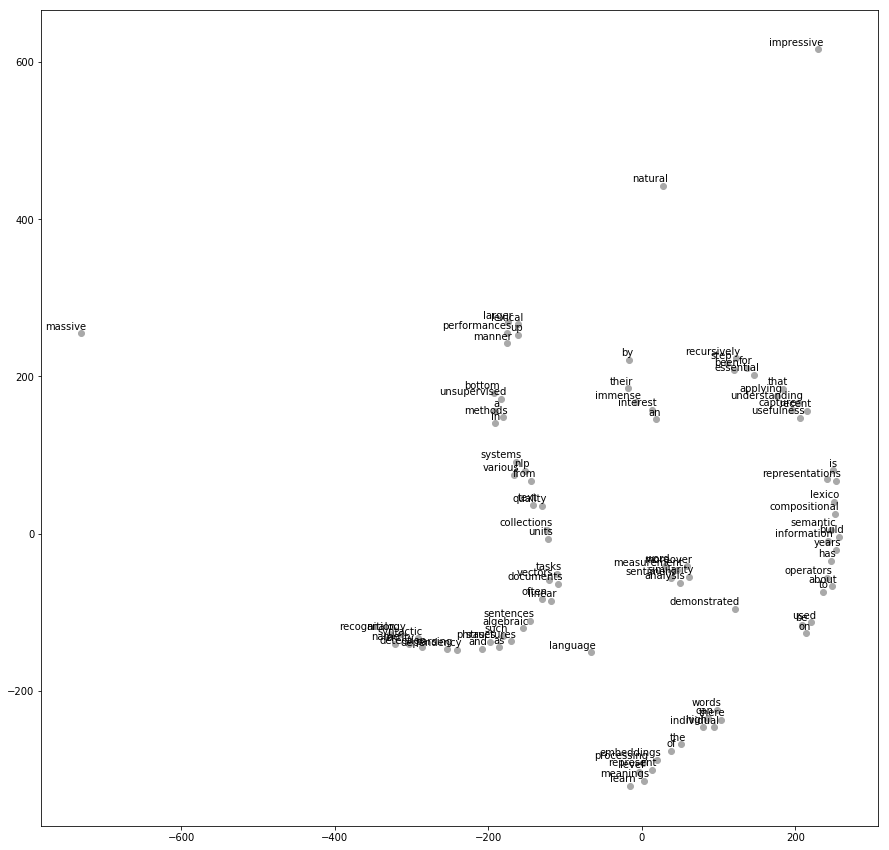

In [16]:


selected_words = ['impressive','words','nlp','sentences','understanding','natural','analysis','demonstrated','used',
                  'massive','parsing','level','quality']

words = [int2Word[i] for i in np.arange(vocabSize)]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y, c='darkgray')   
    if label in listOfAllWordsUnique:
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)
        
pylab.show()
